In [1]:
# train_cifar.py
import os
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------
# Reproducibility / device
# -----------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------
# Hyperparams
# -----------------------
batch_size = 128
num_epochs = 30
learning_rate = 0.01
num_workers = 4  # set 0 on Windows or when debugging
save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

# -----------------------
# Data transforms + loaders
# -----------------------
cifar_mean = [0.4914, 0.4822, 0.4465]
cifar_std  = [0.2470, 0.2435, 0.2616]

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transforms)
val_dataset   = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# -----------------------
# Model: small CNN
# -----------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)),  # 1x1
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model = SimpleCNN(num_classes=10).to(device)

# -----------------------
# Loss, optimizer, scheduler
# -----------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# -----------------------
# Train / validate loops
# -----------------------
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(train_loader, desc=f"Train {epoch}")
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    return running_loss / total, 100.*correct/total

def validate(epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return running_loss/total, 100.*correct/total

best_val_acc = 0.0
for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc = validate(epoch)
    scheduler.step()

    print(f"Epoch {epoch}: Train loss {train_loss:.4f}, acc {train_acc:.2f}% | Val loss {val_loss:.4f}, acc {val_acc:.2f}%")
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
        }, os.path.join(save_dir, "best_cifar_model.pth"))
        print(f"Saved new best model (val acc {val_acc:.2f}%)")

print("Training finished. Best val acc:", best_val_acc)

Device: cpu


100%|████████████████████████████████████████| 170M/170M [00:10<00:00, 16.4MB/s]
Train 1:   0%|                                          | 0/391 [00:00<?, ?it/s]/home/dominique/.local/lib/python3.13/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train 1: 100%|███████████| 391/391 [00:29<00:00, 13.08it/s, acc=39.3, loss=1.66]


Epoch 1: Train loss 1.6598, acc 39.28% | Val loss 1.5044, acc 45.85%
Saved new best model (val acc 45.85%)


Train 2: 100%|███████████| 391/391 [00:35<00:00, 11.05it/s, acc=52.2, loss=1.34]


Epoch 2: Train loss 1.3350, acc 52.21% | Val loss 1.3893, acc 51.10%
Saved new best model (val acc 51.10%)


Train 3: 100%|████████████| 391/391 [00:34<00:00, 11.22it/s, acc=56.9, loss=1.2]


Epoch 3: Train loss 1.2046, acc 56.91% | Val loss 1.2419, acc 54.69%
Saved new best model (val acc 54.69%)


Train 4: 100%|███████████| 391/391 [00:34<00:00, 11.20it/s, acc=59.7, loss=1.14]


Epoch 4: Train loss 1.1381, acc 59.73% | Val loss 1.1434, acc 58.90%
Saved new best model (val acc 58.90%)


Train 5: 100%|███████████| 391/391 [00:35<00:00, 11.13it/s, acc=61.2, loss=1.09]


Epoch 5: Train loss 1.0852, acc 61.25% | Val loss 1.2296, acc 55.84%


Train 6: 100%|███████████| 391/391 [00:35<00:00, 11.13it/s, acc=63.5, loss=1.04]


Epoch 6: Train loss 1.0380, acc 63.47% | Val loss 1.1216, acc 59.51%
Saved new best model (val acc 59.51%)


Train 7: 100%|██████████████| 391/391 [00:34<00:00, 11.19it/s, acc=64.7, loss=1]


Epoch 7: Train loss 1.0040, acc 64.66% | Val loss 1.0824, acc 61.71%
Saved new best model (val acc 61.71%)


Train 8: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s, acc=65.7, loss=0.972]


Epoch 8: Train loss 0.9721, acc 65.73% | Val loss 0.9843, acc 64.62%
Saved new best model (val acc 64.62%)


Train 9: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s, acc=66.9, loss=0.944]


Epoch 9: Train loss 0.9442, acc 66.88% | Val loss 1.0621, acc 63.25%


Train 10: 100%|█████████| 391/391 [00:35<00:00, 11.00it/s, acc=67.5, loss=0.923]


Epoch 10: Train loss 0.9232, acc 67.48% | Val loss 1.0938, acc 61.99%


Train 11: 100%|█████████| 391/391 [00:34<00:00, 11.18it/s, acc=68.6, loss=0.897]


Epoch 11: Train loss 0.8969, acc 68.56% | Val loss 0.9885, acc 64.84%
Saved new best model (val acc 64.84%)


Train 12: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s, acc=69.6, loss=0.87]


Epoch 12: Train loss 0.8704, acc 69.63% | Val loss 0.9514, acc 66.72%
Saved new best model (val acc 66.72%)


Train 13: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s, acc=70.7, loss=0.85]


Epoch 13: Train loss 0.8497, acc 70.70% | Val loss 0.8942, acc 68.21%
Saved new best model (val acc 68.21%)


Train 14: 100%|█████████| 391/391 [00:35<00:00, 11.11it/s, acc=71.4, loss=0.828]


Epoch 14: Train loss 0.8278, acc 71.44% | Val loss 1.0705, acc 62.73%


Train 15: 100%|█████████| 391/391 [00:34<00:00, 11.19it/s, acc=71.8, loss=0.815]


Epoch 15: Train loss 0.8155, acc 71.81% | Val loss 0.9209, acc 68.09%


Train 16: 100%|█████████| 391/391 [00:35<00:00, 11.16it/s, acc=74.7, loss=0.742]


Epoch 16: Train loss 0.7422, acc 74.72% | Val loss 0.7433, acc 74.18%
Saved new best model (val acc 74.18%)


Train 17: 100%|█████████| 391/391 [00:34<00:00, 11.18it/s, acc=75.1, loss=0.729]


Epoch 17: Train loss 0.7292, acc 75.11% | Val loss 0.7345, acc 74.37%
Saved new best model (val acc 74.37%)


Train 18: 100%|█████████| 391/391 [00:35<00:00, 11.11it/s, acc=75.5, loss=0.721]


Epoch 18: Train loss 0.7210, acc 75.50% | Val loss 0.7337, acc 74.80%
Saved new best model (val acc 74.80%)


Train 19: 100%|█████████| 391/391 [00:35<00:00, 11.07it/s, acc=75.7, loss=0.717]


Epoch 19: Train loss 0.7174, acc 75.70% | Val loss 0.7378, acc 74.47%


Train 20: 100%|█████████| 391/391 [00:35<00:00, 11.12it/s, acc=75.5, loss=0.712]


Epoch 20: Train loss 0.7120, acc 75.53% | Val loss 0.7240, acc 75.18%
Saved new best model (val acc 75.18%)


Train 21: 100%|█████████| 391/391 [00:35<00:00, 11.15it/s, acc=75.8, loss=0.712]


Epoch 21: Train loss 0.7124, acc 75.82% | Val loss 0.7319, acc 74.73%


Train 22: 100%|██████████| 391/391 [00:35<00:00, 10.97it/s, acc=75.9, loss=0.71]


Epoch 22: Train loss 0.7096, acc 75.86% | Val loss 0.7217, acc 74.89%


Train 23: 100%|█████████| 391/391 [00:35<00:00, 11.10it/s, acc=76.2, loss=0.702]


Epoch 23: Train loss 0.7020, acc 76.16% | Val loss 0.7222, acc 75.12%


Train 24: 100%|█████████| 391/391 [00:35<00:00, 11.06it/s, acc=76.1, loss=0.702]


Epoch 24: Train loss 0.7025, acc 76.15% | Val loss 0.7183, acc 75.01%


Train 25: 100%|█████████| 391/391 [00:35<00:00, 11.12it/s, acc=76.2, loss=0.699]


Epoch 25: Train loss 0.6987, acc 76.16% | Val loss 0.7133, acc 75.30%
Saved new best model (val acc 75.30%)


Train 26: 100%|█████████| 391/391 [00:33<00:00, 11.83it/s, acc=76.4, loss=0.695]


Epoch 26: Train loss 0.6951, acc 76.37% | Val loss 0.7090, acc 75.43%
Saved new best model (val acc 75.43%)


Train 27: 100%|█████████| 391/391 [00:32<00:00, 11.95it/s, acc=76.3, loss=0.699]


Epoch 27: Train loss 0.6985, acc 76.32% | Val loss 0.7146, acc 75.03%


Train 28: 100%|█████████| 391/391 [00:33<00:00, 11.60it/s, acc=76.6, loss=0.693]


Epoch 28: Train loss 0.6934, acc 76.61% | Val loss 0.7158, acc 75.37%


Train 29: 100%|██████████| 391/391 [00:35<00:00, 11.12it/s, acc=76.7, loss=0.69]


Epoch 29: Train loss 0.6903, acc 76.71% | Val loss 0.7295, acc 74.73%


Train 30: 100%|█████████| 391/391 [00:35<00:00, 11.16it/s, acc=76.6, loss=0.687]


Epoch 30: Train loss 0.6873, acc 76.65% | Val loss 0.7127, acc 75.05%
Training finished. Best val acc: 75.43


In [5]:
# Load best checkpoint
checkpoint = torch.load("./checkpoints/best_cifar_model.pth", map_location=device)

model = SimpleCNN(num_classes=10).to(device)
model.load_state_dict(checkpoint["model_state"])
model.eval()

print("Loaded model from epoch:", checkpoint["epoch"], "with val acc:", checkpoint["val_acc"])

Loaded model from epoch: 26 with val acc: 75.43


In [6]:
test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=val_transforms  # same normalization you defined earlier
)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

print(f"Test accuracy: {100. * correct / total:.2f}%")

Test accuracy: 75.43%


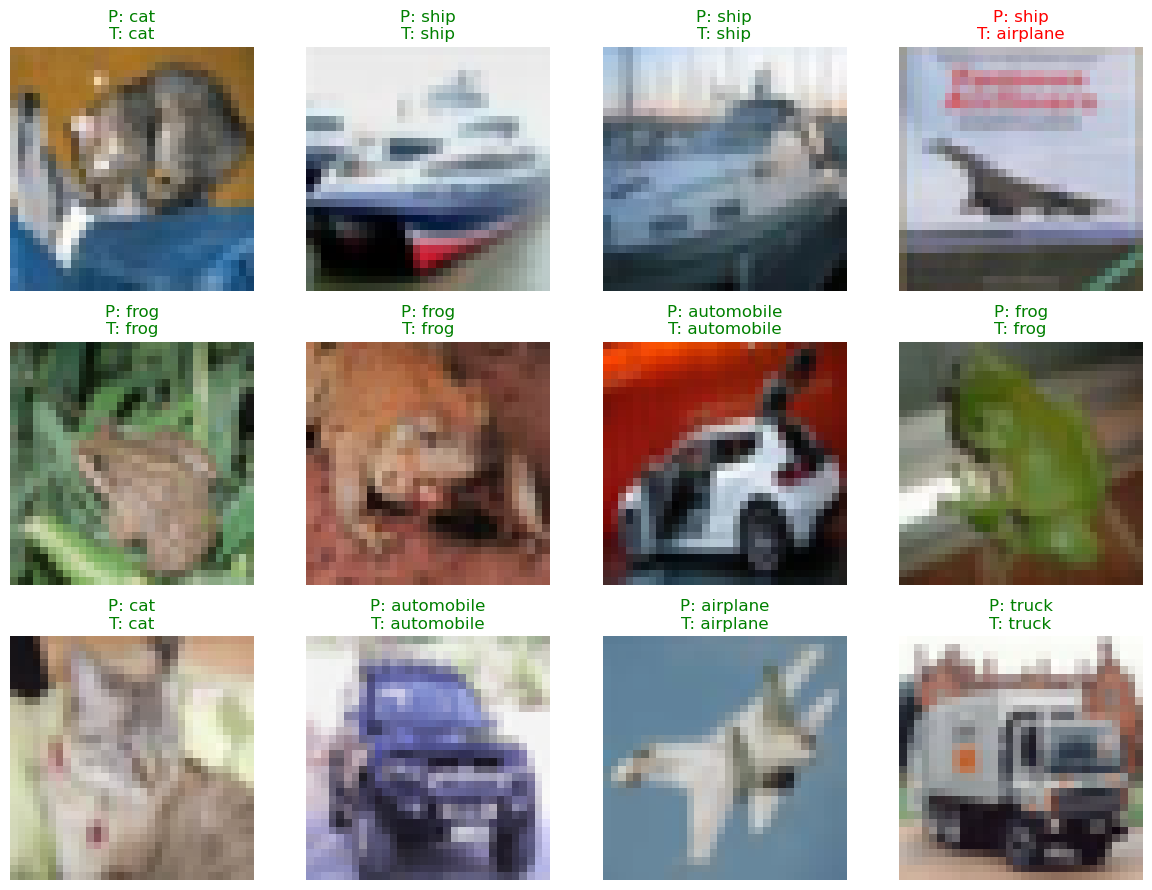

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

# CIFAR-10 classes
classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']

# Load best model
checkpoint = torch.load("./checkpoints/best_cifar_model.pth", map_location=device)
model = SimpleCNN(num_classes=10).to(device)
model.load_state_dict(checkpoint['model_state'])
model.eval()

# Test dataset
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transforms)

# Function to display predictions with color feedback
def show_predictions(model, dataset, num_images=12):
    model.eval()
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.flatten()
    
    for i in range(num_images):
        img, label = dataset[i]
        with torch.no_grad():
            output = model(img.unsqueeze(0).to(device))
            pred = output.argmax(1).item()
        
        # Unnormalize image
        img_np = img.permute(1,2,0).cpu().numpy() * np.array(cifar_std) + np.array(cifar_mean)
        img_np = np.clip(img_np, 0, 1)
        
        axes[i].imshow(img_np)
        axes[i].axis("off")
        
        # Set color: green if correct, red if wrong
        color = 'green' if pred == label else 'red'
        axes[i].set_title(f"P: {classes[pred]}\nT: {classes[label]}", color=color)
    
    plt.tight_layout()
    plt.show()

# Show predictions
show_predictions(model, test_dataset, num_images=12)